In [142]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.2f' % x)

%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, fbeta_score
from sklearn.metrics import precision_recall_curve, roc_curve, log_loss
from sklearn.metrics import make_scorer, confusion_matrix

from time import time

In [3]:
model_names = ["knn", "rf", "et", "xgb"]

for model_name in model_names:
    with open(f"{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [4]:
model_list

[('knn', KNeighborsClassifier(n_neighbors=13, weights='distance')),
 ('rf', RandomForestClassifier(n_estimators=164)),
 ('et', ExtraTreesClassifier(n_estimators=15)),
 ('xgb',
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.8999999999999999,
                early_stopping_rounds=10, eval_metric='logloss', gamma=0,
                gpu_id=-1, importance_type='gain', interaction_constraints='',
                learning_rate=1.2093472472994864, max_delta_step=0, max_depth=5,
                min_child_weight=13.0, missing=nan, monotone_constraints='()',
                n_estimator=50, n_estimators=100, n_jobs=8, num_parallel_tree=1,
                random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.6,
                subsample=0.5, tree_method='exact', validate_parameters=1,
                verbosity=None))]

In [10]:
df = pd.read_csv("features_clean.csv").iloc[:,1:].fillna(df.median())

In [11]:
x, xho, y, yho = train_test_split(df.iloc[:,1:], df.flag, test_size=0.2, random_state=2018)
xtr, xte, ytr, yte = train_test_split(x, y, test_size=0.25, random_state=2019)

### With default threshold

In [144]:
stopwatch = []

for model_name in model_names:
    t0 = time()
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(xho, yho)}')
    stopwatch.append(time() - t0)

knn score: 0.8961303462321792
rf score: 0.9933808553971487
et score: 0.9928716904276986
xgb score: 0.9862525458248472


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [146]:
stopwatch

[0.19925999641418457,
 0.02674412727355957,
 0.004601716995239258,
 0.0025551319122314453]

In [147]:
stopwatch.sort()

In [151]:
stopwatch[:1]
for i in stopwatch:
    print("{:.1f}".format(i/stopwatch[0]))

1.0
1.8
10.5
78.0


In [157]:
def make_confusion_matrix(model, threshold=0.5):
    y_predict = (model.predict_proba(xho)[:, 1] >= threshold)
    model_confusion = confusion_matrix(yho, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(model_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Fraud', 'Legit'],
           yticklabels=['Fraud', 'Legit']);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'RandomForest confusion matrix')
    
    print("Precision: {:6.4f}, Recall: {:6.4f}, F Beta: {:6.4f}".format(precision_score(yho, y_predict), 
                                                     recall_score(yho, y_predict), fbeta_score(yho,y_predict, beta=1.5)))

Precision: 0.7718, Recall: 0.7236, F Beta: 0.7377


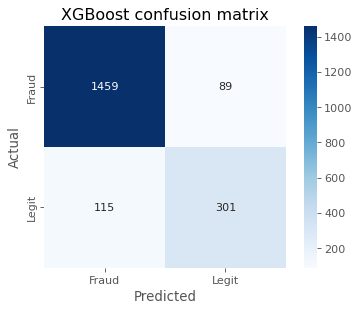

In [152]:
make_confusion_matrix(knn)

Precision: 0.9927, Recall: 0.9760, F Beta: 0.9810


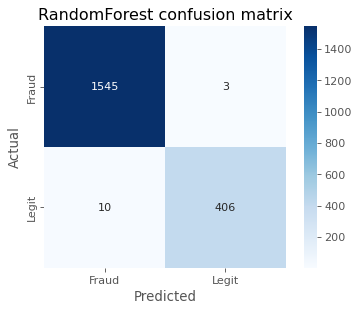

In [163]:
make_confusion_matrix(rf)

Precision: 0.9902, Recall: 0.9760, F Beta: 0.9803


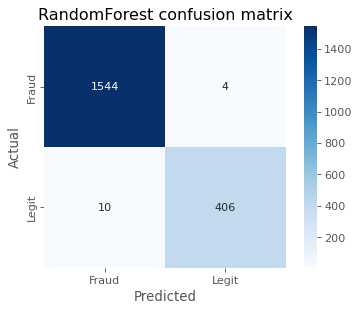

In [164]:
make_confusion_matrix(et)

Precision: 0.9732, Recall: 0.9615, F Beta: 0.9651


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


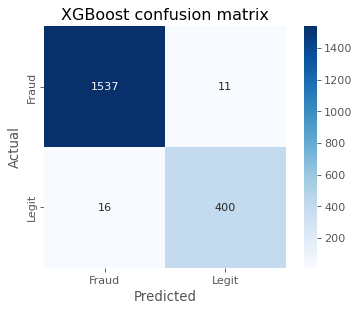

In [119]:
make_confusion_matrix(xgb)

### Picking RandomForest

In [ ]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(et, threshold), threshold=(0.0,1.0,0.02))

#.64

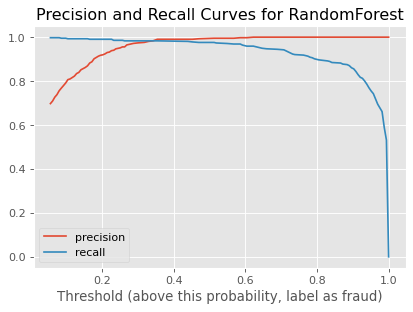

In [100]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(yho, rf.predict_proba(xho)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves for RandomForest');

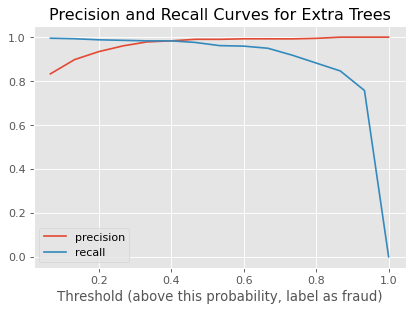

In [101]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(yho, et.predict_proba(xho)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves for Extra Trees');

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
No handles with labels found to put in legend.


ROC AUC score, kNN = 	 	 0.92670
ROC AUC score, RandomForest = 	 0.99911
ROC AUC score, Extra Trees = 	 0.99909
ROC AUC score, XGBoost = 	 0.99716


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


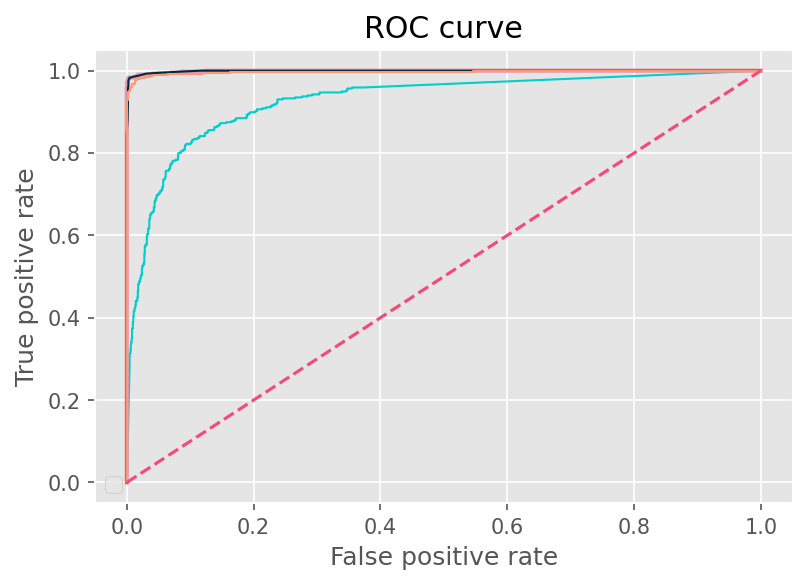

In [141]:
fpr, tpr, thresholds = roc_curve(yho, knn.predict_proba(xho)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(yho, rf.predict_proba(xho)[:,1])
fpr3, tpr3, thresholds3 = roc_curve(yho, et.predict_proba(xho)[:,1])
fpr4, tpr4, thresholds4 = roc_curve(yho, xgb.predict_proba(xho)[:,1])

plt.figure(dpi=150,facecolor='1')

plt.plot(fpr, tpr,lw=1, c='#00cfcc')
plt.plot(fpr2, tpr2,lw=2, c='#e898ac')
plt.plot(fpr3, tpr3,lw=1, c='#002845')
plt.plot(fpr4, tpr4,lw=1, c='#ff9973')

plt.plot([0,1],[0,1],c='#f64975',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc='lower left')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

print("ROC AUC score, kNN = \t \t", '{0:.5f}'.format(roc_auc_score(yho, knn.predict_proba(xho)[:,1])))
print("ROC AUC score, RandomForest = \t", '{0:.5f}'.format(roc_auc_score(yho, rf.predict_proba(xho)[:,1])))
print("ROC AUC score, Extra Trees = \t", '{0:.5f}'.format(roc_auc_score(yho, et.predict_proba(xho)[:,1])))
print("ROC AUC score, XGBoost = \t", '{0:.5f}'.format(roc_auc_score(yho, xgb.predict_proba(xho)[:,1])))

### Log-loss, Time and Complexity

In [108]:
print("Log-loss on kNN: \t\t {:.4f}".format(log_loss(yho, knn.predict_proba(xho))))
print("Log-loss on RandomForest: \t {:.4f}".format(log_loss(yho, rf.predict_proba(xho))))
print("Log-loss on Extra Trees: \t {:.4f}".format(log_loss(yho, et.predict_proba(xho))))
print("Log-loss on XGBoost: \t\t {:.4f}".format(log_loss(yho, xgb.predict_proba(xho))))

Log-loss on kNN: 		 0.6257
Log-loss on RandomForest: 	 0.0371
Log-loss on Extra Trees: 	 0.0334
Log-loss on XGBoost: 		 0.0405


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


### Feature Importance

In [109]:
knn.predict_proba(xho)

array([[1.        , 0.        ],
       [0.54490911, 0.45509089],
       [0.26958559, 0.73041441],
       ...,
       [0.93918639, 0.06081361],
       [1.        , 0.        ],
       [0.31403393, 0.68596607]])

In [110]:
df.head()

,flag,avg min between sent tnx,avg min between received tnx,time diff between first and last (mins),sent tnx,received tnx,number of created contracts,unique received from addresses,unique sent to addresses,min value received,...,erc20 max val rec,erc20 avg val rec,erc20 min val sent,erc20 max val sent,erc20 avg val sent,erc20 uniq sent token name,erc20 uniq rec token name,erc20 most sent token type,erc20 most rec token type,sent rec balance
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.00,...,15000000.00,265586.15,0.00,16830998.35,271779.92,39.00,57.00,1,1,8.10
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.00,...,365.00,57.63,2.26,2.26,2.26,1.00,7.00,1,1,11.75
2,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.11,...,442.82,65.19,0.00,0.00,0.00,0.00,8.00,0,1,0.20
3,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.00,...,11412.23,1555.55,100.00,9029.23,3804.08,1.00,11.00,1,1,2.78
4,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.00,...,90000.00,4934.23,0.00,45000.00,13726.66,6.00,27.00,1,1,229.90
